In [1]:
# code here
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
%matplotlib inline
import os
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from google.colab import drive
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# code here
BATCH_SIZE = 64
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size= BATCH_SIZE, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 48862064.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive

torch.Size([64, 3, 32, 32])
torch.Size([64])


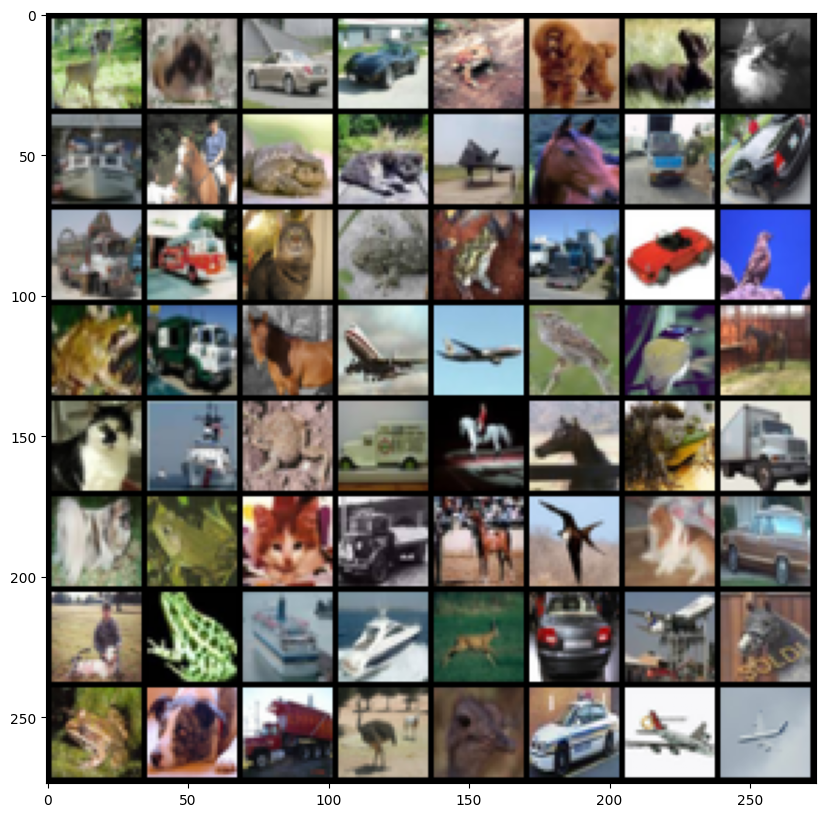

In [6]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

In [7]:
labels = ["AIRPLANE", "AUTOMOBILE", "BIRD", "CAT", "DEER", "DOG", "FROG", "HORSE", "SHIP", "TRUCK"]

## Teacher Model

In [8]:
class Teacher(nn.Module):
    def __init__(self, feature=False):
        super(Teacher, self).__init__()
        self.feature = feature
        self.channel1 = 32
        self.channel2 = 64
        self.channel3 = 128
        self.layer1 = 2048
        self.layer2 = 128

        self.conv1 = nn.Conv2d(3, self.channel1, 3, padding=1)
        self.conv2 = nn.Conv2d(self.channel1, self.channel1, 3, padding=1)

        self.conv3 = nn.Conv2d(self.channel1, self.channel2, 3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(self.channel2, self.channel2, 3, padding=1, stride=1)

        self.conv5 = nn.Conv2d(self.channel2, self.channel3, 3, padding=1)
        self.conv6 = nn.Conv2d(self.channel3, self.channel3, 3, padding=1)

        self.linear1 = nn.Linear(self.layer1, self.layer2)
        self.linear2 = nn.Linear(self.layer2, 10)

        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)
        x, ind2 = self.pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x_n = x
        x, ind4 = self.pool(x)
        x = self.dropout(x)

        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        x, ind6 = self.pool(x)
        x = self.dropout(x)

        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)

        x = self.relu(self.linear2(x))
        # x  = self.sigmoid(x)
        return x_n, x

In [9]:
teacher = Teacher().to(device)
summary(teacher, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5  [[-1, 32, 16, 16], [-1, 32, 16, 16]]               0
           Dropout-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
              ReLU-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,928
             ReLU-10           [-1, 64, 16, 16]               0
        MaxPool2d-11  [[-1, 64, 8, 8], [-1, 64, 8, 8]]               0
          Dropout-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
             ReLU-14 

In [10]:
# code here
def plot_losses(train_loss,val_loss,name):

  x_data=np.arange(0,len(train_loss))
  plt.plot(x_data,train_loss,label="train")
  plt.plot(x_data,val_loss,label="validation")
  plt.legend()
  plt.title(name)
  plt.show()

  return

In [11]:
def train_teacher(model, name, num_epochs=10):
    optimiser = optim.Adam(model.parameters(), lr=1e-3)
    # loss_func = nn.MSELoss().to(device)
    loss_func = nn.CrossEntropyLoss().to(device)
    train_loss, val_loss = list(), list()

    for epoch in range(num_epochs):
        model.train()
        x = 0
        for batch_idx, (data, target) in enumerate(trainloader):
            data = data.to(device)
            target = target.to(device)

            optimiser.zero_grad()

            d_, d = model(data)
            # print(d)
            loss = loss_func(d, target)
            x += loss.cpu().data.item()
            loss.backward()
            optimiser.step()
        x = x / len(trainloader)
        train_loss.append(x)

        model.eval()
        with torch.no_grad():
            x = 0
            for batch_idx, (data, target) in enumerate(testloader):
                data = data.to(device)
                target = target.to(device)

                d_, d = model(data)
                loss = loss_func(d, target)
                x += loss.item()
            x = x/len(testloader)
            val_loss.append(x)
        print("Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch+1,train_loss[-1],val_loss[-1]))
        
    plot_losses(train_loss, val_loss, name)
    return model

Epoch: 1, Train Loss: 2.1007, Test Loss: 1.8572
Epoch: 2, Train Loss: 1.7327, Test Loss: 1.5553
Epoch: 3, Train Loss: 1.4921, Test Loss: 1.0792
Epoch: 4, Train Loss: 1.0710, Test Loss: 0.9329
Epoch: 5, Train Loss: 0.9429, Test Loss: 0.8487
Epoch: 6, Train Loss: 0.8647, Test Loss: 0.8095
Epoch: 7, Train Loss: 0.8096, Test Loss: 0.7355
Epoch: 8, Train Loss: 0.7541, Test Loss: 0.7351
Epoch: 9, Train Loss: 0.7225, Test Loss: 0.7374
Epoch: 10, Train Loss: 0.6794, Test Loss: 0.7204


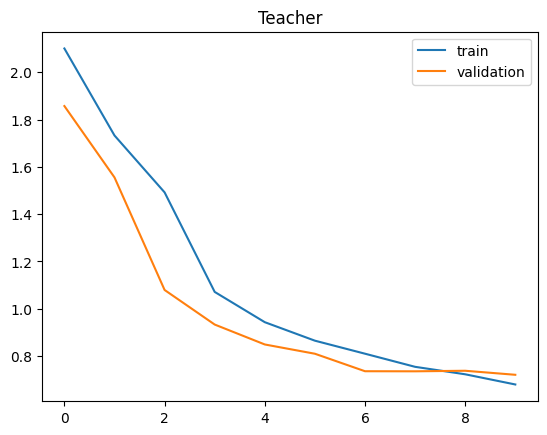

In [ ]:
epochs = 10
teacher = Teacher().to(device)
teacher = train_teacher(teacher, 'Teacher', num_epochs=epochs)

In [ ]:
torch.save(teacher.state_dict(), '/content/drive/MyDrive/teacher.pth')

In [12]:
path =  '/content/drive/MyDrive/teacher.pth'
teacher.load_state_dict(torch.load(path))
teacher

Teacher(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=2048, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# teacher_hint = Teacher(feature=True).to(device)
# summary(teacher_hint, (3,32,32))

In [ ]:
'''
OTHER WORK TO BE DONE
'''

'\nOTHER WORK TO BE DONE\n'

## Student Model

In [ ]:
class Student(nn.Module):
    def __init__(self, feature=False):
        super(Student, self).__init__()
        self.feature = feature
        self.channel1 = 16
        self.channel2 = 32
        self.channel3 = 64
        self.layer1 = 1600
        self.layer2 = 64

        self.conv1 = nn.Conv2d(3, self.channel1, 3, padding=0)
        self.conv2 = nn.Conv2d(self.channel1, self.channel1, 3, padding=1)

        self.conv3 = nn.Conv2d(self.channel1, self.channel2, 3, padding=0, stride=1)
        self.conv4 = nn.Conv2d(self.channel2, self.channel2, 3, padding=1, stride=1)

        self.conv5 = nn.Conv2d(self.channel2, self.channel2, 3, padding=0)
        self.conv6 = nn.Conv2d(self.channel2, self.channel2, 3, padding=1)

        ############### REGRESSOR ################################
        self.S_regressor = nn.Conv2d(self.channel2, self.channel3, 13, padding=1)
        #########################################################

        self.conv7 = nn.Conv2d(self.channel2, self.channel3, 3, padding=0)
        self.conv8 = nn.Conv2d(self.channel3, self.channel3, 3, padding=1)

        self.conv9 = nn.Conv2d(self.channel3, self.channel3, 3, padding=0)
        self.conv10 = nn.Conv2d(self.channel3, self.channel3, 3, padding=1)

        self.linear1 = nn.Linear(self.layer1, self.layer2)
        self.linear2 = nn.Linear(self.layer2, 10)

        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)

        x_n = self.S_regressor(x)

        x = self.conv7(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.relu(x)
        x, ind1 = self.pool(x)

        x = self.conv9(x)
        x = self.relu(x)
        x = self.conv10(x)
        x = self.relu(x)
        x, ind2 = self.pool(x)

        x = self.flatten(x)
        x = self.relu(self.linear1(x))

        x = self.relu(self.linear2(x))
        return x_n, x

In [ ]:
student = Student().to(device)
summary(student, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
              ReLU-2           [-1, 16, 30, 30]               0
            Conv2d-3           [-1, 16, 30, 30]           2,320
              ReLU-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 28, 28]           4,640
              ReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           9,248
              ReLU-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 26, 26]           9,248
             ReLU-10           [-1, 32, 26, 26]               0
           Conv2d-11           [-1, 32, 26, 26]           9,248
             ReLU-12           [-1, 32, 26, 26]               0
           Conv2d-13           [-1, 64, 16, 16]         346,176
           Conv2d-14           [-1, 64,

### Baseline

In [ ]:
def train_student(model, name, num_epochs=10):
    optimiser = optim.Adam(model.parameters(), lr=1e-3)
    # loss_func = nn.MSELoss().to(device)
    loss_func = nn.CrossEntropyLoss().to(device)
    train_loss, val_loss = list(), list()

    for epoch in range(num_epochs):
        model.train()
        x = 0
        for batch_idx, (data, target) in enumerate(trainloader):
            data = data.to(device)
            target = target.to(device)

            optimiser.zero_grad()

            d_, d = model(data)
            loss = loss_func(d, target)
            x += loss.cpu().data.item()
            loss.backward()
            optimiser.step()
        x = x / len(trainloader)
        train_loss.append(x)

        model.eval()
        with torch.no_grad():
            x = 0
            for batch_idx, (data, target) in enumerate(testloader):
                data = data.to(device)
                target = target.to(device)

                d_, d = model(data)
                loss = loss_func(d, target)
                x += loss.item()
            x = x/len(testloader)
            val_loss.append(x)
        print("Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch+1,train_loss[-1],val_loss[-1]))
        
    plot_losses(train_loss, val_loss, name)
    return model

Epoch: 1, Train Loss: 2.1030, Test Loss: 1.8701
Epoch: 2, Train Loss: 1.7363, Test Loss: 1.5995
Epoch: 3, Train Loss: 1.5372, Test Loss: 1.4897
Epoch: 4, Train Loss: 1.3876, Test Loss: 1.3436
Epoch: 5, Train Loss: 1.2883, Test Loss: 1.3071
Epoch: 6, Train Loss: 1.1970, Test Loss: 1.2426
Epoch: 7, Train Loss: 1.1272, Test Loss: 1.1514
Epoch: 8, Train Loss: 1.0739, Test Loss: 1.1258
Epoch: 9, Train Loss: 1.0235, Test Loss: 1.1267
Epoch: 10, Train Loss: 0.9806, Test Loss: 1.1502


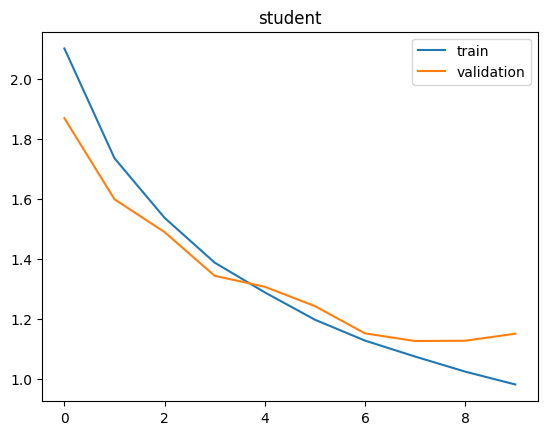

In [ ]:
epochs = 10
student = Student().to(device)
student = train_student(student, 'student', num_epochs=epochs)

In [ ]:
torch.save(student.state_dict(), '/content/drive/MyDrive/student.pth')

In [ ]:
path =  '/content/drive/MyDrive/student.pth'
student.load_state_dict(torch.load(path))
student

Student(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (S_regressor): Conv2d(32, 64, kernel_size=(13, 13), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1600, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
'''
OTHER WORK TO BE DONE
'''

'\nOTHER WORK TO BE DONE\n'

## Distiller

In [ ]:
def distiller(teacher_model, student_model, alpha=0.1, temperature=3, is_KD_train=False, num_epochs=5):
    optimiser = optim.Adam(student_model.parameters(), lr=1e-3)
    # loss_func = nn.MSELoss().to(device)
    student_loss_fn = nn.CrossEntropyLoss().to(device)
    # distillation_loss_fn = nn.CrossEntropyLoss().to(device)
    # distillation_loss_fn = nn.MSELoss().to(device) # for FitNets
    distillation_loss_fn = nn.KLDivLoss().to(device) # for Hinton
    softmax = nn.Softmax(dim=1)
    train_loss, val_loss = list(), list()
    student_loss_train = list()

    for epoch in range(num_epochs):
        student_model.train()
        x = 0
        for batch_idx, (data, target) in enumerate(trainloader):
            data = data.to(device)
            target = target.to(device)

            optimiser.zero_grad()

            teacher_preds1, teacher_preds2 = teacher_model(data)
            student_preds1, student_preds2 = student_model(data)
            # Compute student loss
            if is_KD_train == True:
                student_loss = student_loss_fn(student_preds2, target)
                teacher_pred_mod = softmax(teacher_preds2/temperature)
                student_pred_mod = softmax(student_preds2/temperature)
            else:
                student_loss = 0.0
                teacher_pred_mod = softmax(teacher_preds1/temperature)
                student_pred_mod = softmax(student_preds1/temperature)

            # Compute distillation loss
            distillation_loss = distillation_loss_fn(student_pred_mod, teacher_pred_mod)

            # Compute aggregate loss
            loss = alpha*distillation_loss + (1 - alpha)*student_loss
            # print('loss', loss)

            x += loss.cpu().data.item()
            loss.backward()
            optimiser.step()
        x = x / len(trainloader)
        train_loss.append(x)

        student_model.eval()
        with torch.no_grad():
            x = 0
            for batch_idx, (data, target) in enumerate(testloader):
                data = data.to(device)
                target = target.to(device)

                d_, d = student_model(data)
                loss = student_loss_fn(d, target)
                x += loss.item()
            x = x/len(testloader)
            val_loss.append(x)
        if is_KD_train:
            print("Epoch: {}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch+1,train_loss[-1],val_loss[-1]))
        else:
            print("Epoch: {}, Train Loss: {:.4f}".format(epoch+1,train_loss[-1]))
        
    plot_losses(train_loss, val_loss, "student")

### Response Based Learning

Epoch: 1, Train Loss: 1.9458, Test Loss: 1.5986
Epoch: 2, Train Loss: 1.6551, Test Loss: 1.4067
Epoch: 3, Train Loss: 1.4960, Test Loss: 1.2628
Epoch: 4, Train Loss: 1.3802, Test Loss: 1.1577
Epoch: 5, Train Loss: 1.2940, Test Loss: 1.0275


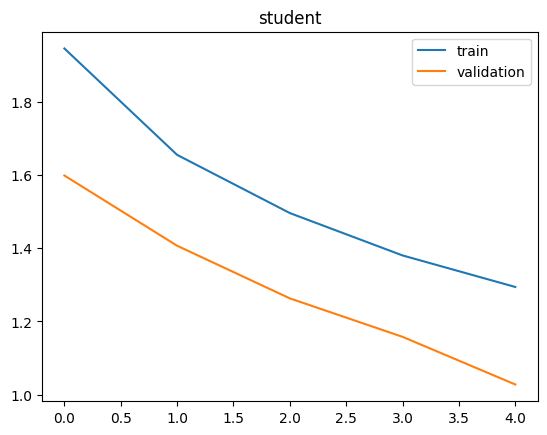

In [ ]:
student_resp = Student().to(device)
distiller(teacher, student_resp, alpha=0.2, temperature=10, is_KD_train=True)

### Feature based learning

In [ ]:
student_guided = Student().to(device)
student_guided

Student(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (S_regressor): Conv2d(32, 64, kernel_size=(13, 13), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1600, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

Epoch: 1, Train Loss: 1.1340
Epoch: 2, Train Loss: 1.0476
Epoch: 3, Train Loss: 1.0195
Epoch: 4, Train Loss: 1.0050
Epoch: 5, Train Loss: 0.9955
Epoch: 6, Train Loss: 0.9892
Epoch: 7, Train Loss: 0.9814
Epoch: 8, Train Loss: 0.9761
Epoch: 9, Train Loss: 0.9721
Epoch: 10, Train Loss: 0.9690


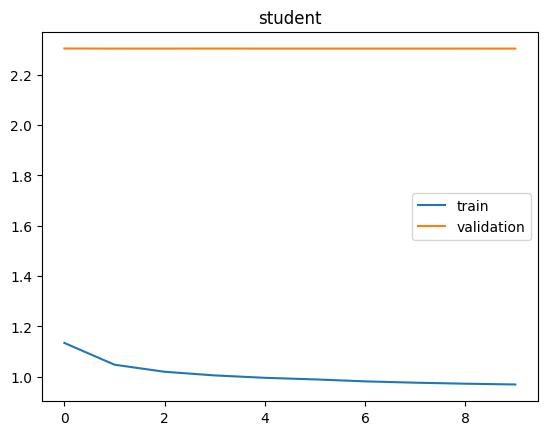

In [ ]:
distiller(teacher, student_guided, alpha=1, temperature=5)